In [112]:
from bs4 import BeautifulSoup
import time
import requests
import urllib.request
import pandas as pd
import numpy as np
import os
from glob import glob
from datetime import datetime
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from pathlib import Path # for recursive access to folder
from fnmatch import fnmatch
import csv
from functools import reduce
import random
import pytz
#pip install holidays
import holidays

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score, TimeSeriesSplit, train_test_split
from sklearn.feature_selection import RFE, RFECV
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
os.chdir('../')
alt.data_transformers.disable_max_rows()
pd.set_option('display.max_columns', None) 
pd.options.mode.chained_assignment = None

# Introduction

2015-2019 data

In [42]:
# Initialize empty dictionary to save all the errors from different models
dict_error = dict()

In [43]:
def error_metrics(y_pred, y_true, model_name = None, test = True):
    """
    Prints root mean square error, R2 score, mean absolute error, mean absolute % error. 
    
    y_pred: predicted values of y using the model model_name
    y_truth: observed values of y
    model_name: name of the model used for predictions
    test: if validating on test set, True; otherwise False for training set validation
    
    The function will print the RMSE, R2, MAE and MAPE error metrics for the model_name and also store the results along with 
    model_name in the dictionary dict_error so that we can compare all the models at the end.
    """
    if isinstance(y_pred, np.ndarray):
        y_pred = y_pred
    else:
        y_pred = y_pred.to_numpy()
        
    if isinstance(y_true, np.ndarray):
        y_true = y_true
    else:
        y_true = y_true.to_numpy()
        
    print('\nError metrics for model {}'.format(model_name))
    
    RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
    print("RMSE or Root mean squared error: %.2f" % RMSE)
    
    # Explained variance score: 1 is perfect prediction

    R2 = r2_score(y_true, y_pred)
    print('Variance score: %.2f' % R2 )

    MAE = mean_absolute_error(y_true, y_pred)
    print('Mean Absolute Error: %.2f' % MAE)

    MAPE = (np.mean(np.abs((y_true - y_pred) / y_true)) * 100)
    print('Mean Absolute Percentage Error: %.2f %%' % MAPE)
    
    # Appending the error values along with the model_name to the dict
    if test:
        train_test = 'test'
    else:
        train_test = 'train'
    
    name_error = ['model', 'train_test', 'RMSE', 'R2', 'MAE', 'MAPE']
    value_error = [model_name, train_test, RMSE, R2, MAE, MAPE]
    list_error = list(zip(name_error, value_error))
    
    for error in list_error:
        if error[0] in dict_error:
            # append the new number to the existing array at this slot
            dict_error[error[0]].append(error[1])
        else:
            # create a new array in this slot
            dict_error[error[0]] = [error[1]]

## Scraping electricity demand data

In [45]:
def get_ieso_data(start_year = 2015, end_year = 2019):
    """Scraping ieso data"""
    years = [i for i in range(start_year, end_year + 1)]

    url_base = "http://reports.ieso.ca/public/Demand/"

    urls = []
    for year in years:
        urls.append(url_base + "PUB_Demand_" + str(year) + ".csv")


    r  = requests.get(url_base)
    data = r.text
    soup = BeautifulSoup(data,features="html5lib")

    filenames = []
    for link in soup.find_all('a'):
        if link.get('href').endswith(".csv"):
            filenames.append(url_base+link.get('href'))

    for url in urls:
        assert url in filenames

    column_names = ['date', 'hour', 'market_demand', 'ontario_demand']
    combined_csv = pd.concat([pd.read_csv(url, skiprows=4, names = column_names) for url in urls], ignore_index=True)
    assert len(urls) == len(set(urls)) #Check that there are no duplicate filenames
    
    return combined_csv

## Daylight Saving Adjustment

The datetime index will be adjusted by converting the timezone naive date to UTC for universal convenience. The `convert_local_utc_time` function has the flexibility to convert back to Eastern time after adjusting for Daylight saving

In [46]:
def convert_local_utc_time(date_series, Eastern_Time = False):
    """Convert naive times to utc"""
    DateTime_UTC = date_series.dt.tz_localize('UTC') + pd.Timedelta(hours=5)
    
    #Convert back to Eastern time with aware efficiency (if necessary)
    if Eastern_Time:
        DateTime_EST = DateTime_UTC.dt.tz_convert('America/Toronto')
        return DateTime_EST
    
    return DateTime_UTC

# weather_ieso_data = combine_weather_ieso_data()

In [47]:
def combine_date_time(df):    
    """Combines and converts string date and time as datetime object"""
    return pd.to_datetime(df['date']).combine(pd.to_datetime(df['date']), datetime.time(df['hour']))

def preprocess_ieso_date_time():
    ieso_data = get_ieso_data(2015, 2019)
    ieso_data.date = pd.to_datetime(ieso_data.date)

    ieso_data['hour'] = ieso_data['hour'] - 1

    ieso_data['date_time'] = ieso_data.apply(combine_date_time, axis = 1)


    ieso_data = ieso_data.set_index('date_time')

    ieso_data = ieso_data.drop(columns = ['ontario_demand', 'date', 'hour'])
    ieso_data.index = convert_local_utc_time(ieso_data.index.to_series(), Eastern_Time = False) #Changing time to UTC
    ieso_data.to_csv("data/cleaned/ieso_data.csv", index=False)
    return ieso_data

ieso_data = preprocess_ieso_date_time()

In [48]:
ieso_data.head()

,market_demand
date_time,
2015-01-01 05:00:00+00:00,18358
2015-01-01 06:00:00+00:00,18012
2015-01-01 07:00:00+00:00,17795
2015-01-01 08:00:00+00:00,17559
2015-01-01 09:00:00+00:00,17402


In [49]:
ieso_data.describe()

,market_demand
count,43824.000000
mean,17749.895240
std,2230.171802
min,12316.000000
25%,16114.000000
50%,17565.000000
75%,19203.000000
max,26087.000000


In [50]:
ieso_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2015-01-01 05:00:00+00:00 to 2020-01-01 04:00:00+00:00
Freq: H
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   market_demand  43824 non-null  int64
dtypes: int64(1)
memory usage: 684.8 KB


In [51]:
print("Autocorrelation on market demand: {:.3f}".format(ieso_data.market_demand.autocorr()))

Autocorrelation on market demand: 0.967


In [52]:
ieso_data.shape

(43824, 1)

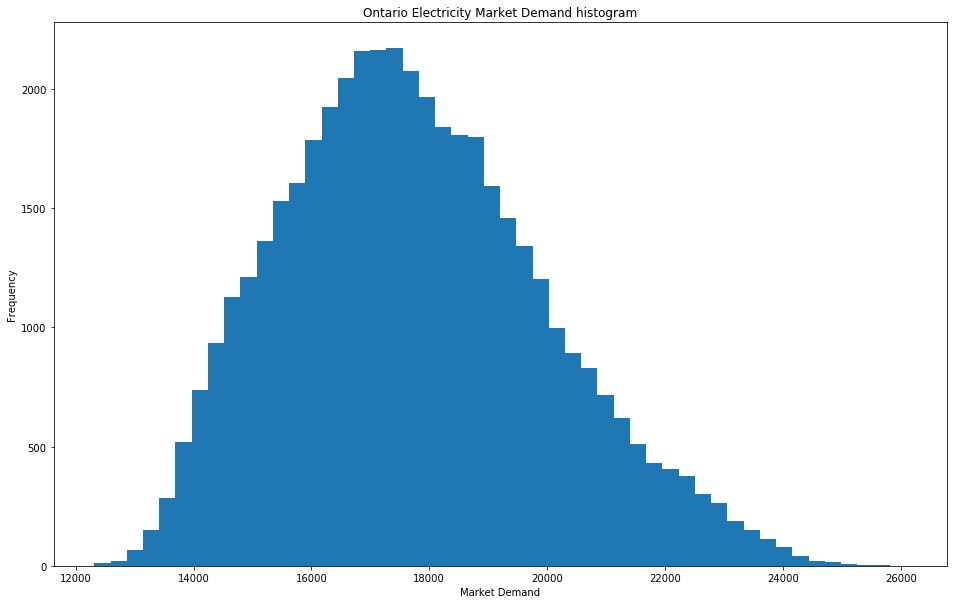

In [53]:
plt.figure()

ieso_data['market_demand'].plot(kind="hist", stacked=True, bins=50)

plt.title("Ontario Electricity Market Demand histogram")
plt.xlabel("Market Demand")
plt.show();

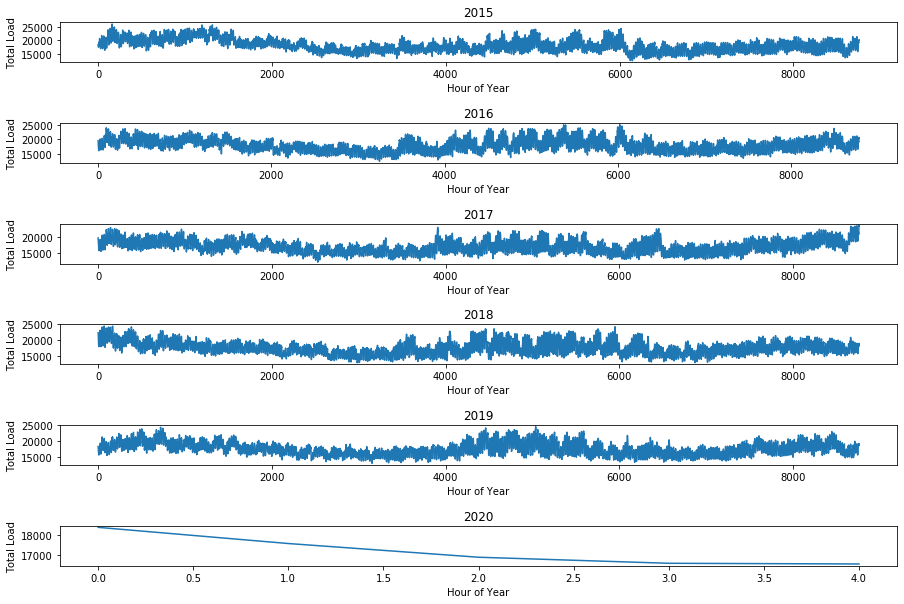

In [54]:
##### Plot the yearly actual loads

#group data by year
groups = ieso_data['market_demand'].groupby(pd.Grouper(freq='A'))

#set figure and axis
fig, axs = plt.subplots(len(groups), 1, figsize=(15,10))


for ax, (name, group) in zip(axs, groups):
    
    #plot the data
    ax.plot(pd.Series(group.values))

    ax.set_xlabel('Hour of Year')
    ax.set_ylabel('Total Load')
    ax.set_title(name.year)
    plt.subplots_adjust(hspace=1.5)

## Station Samples from each Zone
#### Preprocessing for weather data downloading using https://framagit.org/MiguelTremblay/get_canadian_weather_observations/blob/master/README.md

In [57]:
# Fetch Station inventory
def get_station_inventory(province = 'ONTARIO'):
    col_names = ['Name', 'Province', 'Climate ID', 'Station ID', 'WMO ID', 'TC ID', 
                 'Latitude (Decimal Degrees)', 'Longitude (Decimal Degrees)', 'Latitude', 
                 'Longitude', 'Elevation (m)', 'First Year', 'Last Year', 'HLY First Year', 
                 'HLY Last Year', 'DLY First Year', 'DLY Last Year', 'MLY First Year', 'MLY Last Year']

    stn = pd.read_csv("https://framagit.org/MiguelTremblay/get_canadian_weather_observations/-/raw/master/station_list/Station%20Inventory%20EN.csv",  
                 skiprows=4, header=None, names=col_names)

    stn = stn[stn['Province'] == province] #Ontario of interest
    return stn


def get_ieso_generation_list():
    gen_list = pd.read_excel('http://www.ieso.ca/-/media/Files/IESO/Document-Library/power-data/supply/IESO-Active-Contracted-Generation-List.xlsx?la=en', 
              skiprows = 2, sheet_name = 'Contract Data')

    gen_list = gen_list.rename(columns = {'Closet City/Town':'Name'})

    gen_list['Name'] = gen_list['Name'].apply(lambda x: str(x).upper())
    return gen_list

def get_top_station_rows():
    top_rows = pd.read_csv("https://framagit.org/MiguelTremblay/get_canadian_weather_observations/-/raw/master/station_list/Station%20Inventory%20EN.csv", 
                           header=None, nrows=3)
    return top_rows


def sample_stations():
    
    station_zone_info = [{'Name':'THUNDER BAY', 'Station_ID': 49389, 'Zone': 'Northwest'},
          {'Name':'LONDON', 'Station_ID': 50093, 'Zone': 'West'},
          {'Name':'OSHAWA', 'Station_ID': 48649, 'Zone': 'Toronto'},
          {'Name':'KITCHENER', 'Station_ID': 48569, 'Zone': 'Southwest'},
          {'Name':'OTTAWA INTL A', 'Station_ID': 49568, 'Zone': 'Ottawa'},
          {'Name':'PETERBOROUGH', 'Station_ID': 48952, 'Zone': 'East'},
          {'Name':'MOUNT FOREST (AUT)', 'Station_ID': 7844, 'Zone': 'Bruce'},
          {'Name':'BARRIE-ORO', 'Station_ID': 42183, 'Zone': 'Essa'},
          {'Name':'WELLAND-PELHAM', 'Station_ID': 44283, 'Zone': 'NIAGARA'},
          {'Name':'NORTH BAY A', 'Station_ID': 52318, 'Zone': 'Northeast'}, 
         ]
    sample_zone_df = pd.DataFrame(station_zone_info)
    return sample_zone_df

def preprocess_station_inventory():
    Station_Inventory = get_station_inventory().merge(get_ieso_generation_list(), on='Name', how='inner')
    columns_to_drop = ['Station ID', 'Zone', 'Station_ID']
    
    #Station_Inventory_EN.merge(sample_zone_df, on = 'Name', how = 'inner').drop(columns = columns_to_drop)
    Station_Inventory_EN = Station_Inventory.merge(sample_stations(), on = 'Name', how='inner').drop(columns = columns_to_drop)
    Station_Inventory_EN[['First Year', 'Last Year', 'HLY First Year', 
                          'HLY Last Year', 'DLY First Year', 
                      'DLY Last Year', 'MLY First Year', 'MLY Last Year']] = Station_Inventory_EN[['First Year', 'Last Year',
                                                                               'HLY First Year', 'HLY Last Year', 'DLY First Year', 'DLY Last Year',
                                                                                'MLY First Year', 'MLY Last Year']].fillna(0).apply(np.int64).replace(0, '')
    return Station_Inventory_EN

#For storing Station_Inventory_EN and downloading weather data
def Save_Station_Inventory_EN(path_to_file):
    top_rows = get_top_station_rows()
    Station_Inventory_EN = preprocess_station_inventory()
    Station_Inventory_EN.to_csv(path_to_file, index=False)

    with open(path_to_file, newline='') as f:
        r = csv.reader(f)
        data = [line for line in r]
    with open(path_to_file,'w',newline='') as f:
        w = csv.writer(f)
        w.writerow([top_rows[0][0]])
        w.writerow([top_rows[0][1]])
        w.writerow([top_rows[0][2]])
        w.writerows(data)
full_path = "../bluewaveai/get_canadian_weather_observations/station_list/Station Inventory EN.csv"    
Save_Station_Inventory_EN(full_path)

Now that Station Inventory is saved, we can download weather data using script from https://framagit.org/MiguelTremblay/get_canadian_weather_observations/blob/master/README.md

In [12]:
# download weather data
# !python get_canadian_weather_observations.py --hourly --start-date 2016-01 --end-date 2019-12 --station-file "/Users/moby/MDS/bluewaveai/get_canadian_weather_observations/station_list/Station Inventory EN.csv" --lang en -o /Users/moby/MDS/bluewaveai/data/new ON

## Feature Engineering for Weather Data

In [75]:
# Capturing and encoding all weather conditions as snow, cloud, rain, thunderstorm, fog or clear
def snow(x):
    if 'snow' in x.lower():
        return 1
    return 0

def cloud(x):
    if 'cloud' in x.lower():
        return 1
    return 0


def rain(x):
    if 'rain' in x.lower() or 'drizzle' in x.lower():
        return 1
    return 0

def thunderstorm(x):
    if 'thunderstorm' in x.lower():
        return 1
    return 0

def fog(x):
    if 'fog' in x.lower() or 'haze' in x.lower():
        return 1
    return 0

    
def clear(x):
    if 'clear' in x.lower() or (snow(x) == cloud(x) == rain(x) == thunderstorm(x) == fog(x) == 0):
        return 1
    return 0


## Adding Season

In [95]:
def winter(month):
    """Adding winter season: months from November to May denoted as 'winter'. """
    if month not in [6,7,8,9,10]:
        return 1
    else:
        return 0

def summer(month):
    """Adding summer season: months from June to October are denoted as 'summer'. """
    if month in [6,7,8,9,10]:
        return 1
    else:
        return 0 

## Adding Public holidays in Ontario

In [149]:
def can_holidays(full_date, years_list, province='ON'):
    
    pub_holidays = holidays.Canada(prov=province, years = years_list)
    if full_date in pub_holidays:
        return 1
    return 0

In [15]:
# weather_df = pd.read_csv("data/cleaned/weather_df.csv", engine = 'python')

In [158]:
def load_weather_data_reg(files_path):

    station_df_list = [] #Stores each weather dataframe from each station
    df_count = 1
    for root, dirs, files in os.walk(files_path):
        file_list = []
        for filename in files:
            if filename.endswith('.csv'):
                file_list.append(os.path.join(root, filename)) 
        df_list = [pd.read_csv(file) for file in file_list]
        if df_list:
            final_df = pd.concat(df_list)
            #Dropping columns with 80% or more missing data
            final_df = final_df[final_df.columns[final_df.isnull().mean() < 0.8]]
            try:
                #filling nas
                final_df['Weather'] = final_df['Weather'].fillna(method='pad').fillna(method='bfill') #forward fill then backfill for complete elimination of nas
                #Converting Weather/precipitation to string
                final_df['Weather'] = final_df['Weather'].astype(str)
                # Create precipitation variables
                final_df['snow'] = final_df['Weather'].apply(snow)
                final_df['cloud'] = final_df['Weather'].apply(cloud)
                final_df['rain'] = final_df['Weather'].apply(rain)
                final_df['thunderstorm'] = final_df['Weather'].apply(thunderstorm)
                final_df['fog'] = final_df['Weather'].apply(fog)
                final_df['clear'] = final_df['Weather'].apply(clear)
            except:
                pass
            # Renaming columns by adding '_' dataframe number except date/time to be used for joining other station data
            final_df.rename(columns={col:'{}_{}'.format(col, df_count) for col in list(set(final_df.columns) - set(['Date/Time']))}, 
                  inplace=True)
            df_count+=1
            station_df_list.append(final_df)

    weather_data = reduce(lambda left,right: pd.merge(left,right,on=['Date/Time'],
                                                how='outer'), station_df_list)

    weather_data['date_time'] = pd.to_datetime(weather_data['Date/Time'])
    weather_data = weather_data.sort_values(['date_time'])
    weather_data = weather_data.set_index('date_time')

    #Dropping Year, Month and Day separate columns
    weather_data = weather_data[weather_data.columns.drop(list(weather_data.filter(regex='Year')))] #Drop Year column
    weather_data = weather_data[weather_data.columns.drop(list(weather_data.filter(regex='Month')))] #Drop Month
    weather_data = weather_data[weather_data.columns.drop(list(weather_data.filter(regex='Day')))] #Drop Day columns
    weather_data = weather_data[weather_data.columns.drop(list(weather_data.filter(regex='Climate')))] # Remove Climate Columns
    weather_data = weather_data[weather_data.columns.drop(list(weather_data.filter(regex='Longitude')))] # Drop longitude
    weather_data = weather_data[weather_data.columns.drop(list(weather_data.filter(regex='Latitude')))] #Drop latitude
    weather_data = weather_data[weather_data.columns.drop(list(weather_data.filter(regex='Weather')))] # Drop Weather columns
    
    # Create weekday boolean feature
    weather_data['weekday'] = (weather_data.index.weekday < 5).astype(int)
    # Create sine/cosine transformation for the hour of the day
    weather_data['sin_hour'] = np.sin(2*np.pi*weather_data.index.hour.values/24)# See notes below
    weather_data['cos_hour'] = np.cos(2*np.pi*weather_data.index.hour.values/24)
    
    # Adding seasons
    weather_data['winter'] = weather_data.index.month.map(winter)
    weather_data['summer'] = weather_data.index.month.map(summer)
    
    #Adding Public holidays
    weather_data['holiday'] = weather_data.index.map(lambda x: can_holidays(x, years_list=list(weather_data.index.year.unique())))
    
    weather_data = weather_data.select_dtypes(exclude='object')
    weather_data.index = convert_local_utc_time(weather_data.index.to_series(), Eastern_Time = False) #Changing time to UTC
    #Saving dataframe as csv
    weather_data.to_csv("data/cleaned/weather_final_df.csv", index=False )
    
    return weather_data

weather_data = load_weather_data_reg("data/weather")

In [159]:
weather_data

,Temp (°C)_1,Dew Point Temp (°C)_1,Rel Hum (%)_1,Wind Dir (10s deg)_1,Wind Spd (km/h)_1,Stn Press (kPa)_1,Wind Chill_1,Temp (°C)_2,Dew Point Temp (°C)_2,Rel Hum (%)_2,Wind Dir (10s deg)_2,Wind Spd (km/h)_2,Visibility (km)_2,Stn Press (kPa)_2,Wind Chill_2,Temp (°C)_3,Dew Point Temp (°C)_3,Rel Hum (%)_3,Wind Dir (10s deg)_3,Wind Spd (km/h)_3,Stn Press (kPa)_3,Wind Chill_3,Temp (°C)_4,Dew Point Temp (°C)_4,Rel Hum (%)_4,Wind Dir (10s deg)_4,Wind Spd (km/h)_4,Visibility (km)_4,Stn Press (kPa)_4,Wind Chill_4,Temp (°C)_5,Dew Point Temp (°C)_5,Rel Hum (%)_5,Wind Dir (10s deg)_5,Wind Spd (km/h)_5,Visibility (km)_5,Stn Press (kPa)_5,Wind Chill_5,snow_5,cloud_5,rain_5,thunderstorm_5,fog_5,clear_5,Temp (°C)_6,Dew Point Temp (°C)_6,Rel Hum (%)_6,Wind Dir (10s deg)_6,Wind Spd (km/h)_6,Visibility (km)_6,Stn Press (kPa)_6,Wind Chill_6,snow_6,cloud_6,rain_6,thunderstorm_6,fog_6,clear_6,Temp (°C)_7,Dew Point Temp (°C)_7,Rel Hum (%)_7,Wind Dir (10s deg)_7,Wind Spd (km/h)_7,Stn Press (kPa)_7,Wind Chill_7,Temp (°C)_8,Dew Point Temp (°C)_8,Rel Hum (%)_8,Wind Dir (10s deg)_8,Wind Spd (km/h)_8,Visibility (km)_8,Stn Press (kPa)_8,Wind Chill_8,snow_8,cloud_8,rain_8,thunderstorm_8,fog_8,clear_8,Temp (°C)_9,Dew Point Temp (°C)_9,Rel Hum (%)_9,Wind Dir (10s deg)_9,Wind Spd (km/h)_9,Visibility (km)_9,Stn Press (kPa)_9,Wind Chill_9,snow_9,cloud_9,rain_9,thunderstorm_9,fog_9,clear_9,Temp (°C)_10,Dew Point Temp (°C)_10,Rel Hum (%)_10,Wind Dir (10s deg)_10,Wind Spd (km/h)_10,Visibility (km)_10,Stn Press (kPa)_10,Wind Chill_10,snow_10,cloud_10,rain_10,thunderstorm_10,fog_10,clear_10,weekday,sin_hour,cos_hour,winter,summer,holiday
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 05:00:00+00:00,-9.8,-10.7,93.0,24.0,23.0,96.26,-18.0,-10.3,-15.3,67.0,25.0,17.0,16.1,98.08,-18.0,-9.4,-13.3,73.0,23.0,16.0,97.69,-16.0,-7.2,-15.3,53.0,24.0,26.0,16.1,99.80,-15.0,-9.4,-10.6,91.0,23.0,18.0,16.1,96.03,-17.0,0,0,1,0,0,0,-8.3,-15.6,56.0,24.0,31.0,24.1,98.31,-17.0,0,1,0,0,0,0,-6.5,-14.8,52.0,28.0,26.0,99.56,-14.0,-7.3,-14.7,56.0,22.0,32.0,24.1,99.77,-16.0,0,1,0,0,0,0,-8.7,-16.0,56.0,23.0,37.0,16.1,97.60,-19.0,0,0,0,0,1,0,-8.0,-13.3,66.0,24.0,18.0,16.1,99.00,-15.0,1,0,0,0,0,0,1,0.000000,1.000000,1,0,1
2015-01-01 06:00:00+00:00,-9.5,-10.8,90.0,23.0,23.0,96.20,-18.0,-10.6,-15.2,70.0,25.0,15.0,16.1,98.03,-17.0,-9.2,-13.3,72.0,25.0,19.0,97.61,-17.0,-7.6,-15.4,54.0,23.0,18.0,16.1,99.68,-14.0,-9.4,-10.8,89.0,27.0,24.0,6.4,96.02,-18.0,1,0,0,0,0,0,-8.4,-15.1,59.0,24.0,32.0,24.1,98.24,-18.0,0,1,0,0,0,0,-6.6,-15.7,48.0,27.0,31.0,99.50,-15.0,-7.1,-14.5,56.0,22.0,26.0,24.1,99.71,-15.0,0,1,0,0,0,0,-8.9,-15.3,60.0,24.0,35.0,16.1,97.50,-19.0,0,0,0,0,1,0,-7.9,-14.0,62.0,24.0,26.0,16.1,98.93,-16.0,1,0,0,0,0,0,1,0.258819,0.965926,1,0,1
2015-01-01 07:00:00+00:00,-9.1,-10.2,91.0,24.0,23.0,96.19,-17.0,-11.0,-15.0,73.0,23.0,13.0,16.1,97.95,-17.0,-8.7,-12.4,74.0,24.0,21.0,97.57,-16.0,-7.5,-15.6,53.0,23.0,18.0,16.1,99.67,-14.0,-9.7,-11.7,86.0,26.0,22.0,16.1,95.98,-18.0,1,0,0,0,0,0,-7.8,-14.1,61.0,24.0,30.0,24.1,98.23,-17.0,0,1,0,0,0,0,-6.6,-14.4,54.0,26.0,22.0,99.46,-14.0,-7.1,-14.5,56.0,23.0,26.0,24.1,99.69,-15.0,0,1,0,0,0,0,-8.5,-14.4,63.0,23.0,37.0,16.1,97.52,-18.0,0,0,0,0,1,0,-8.3,-14.0,64.0,23.0,22.0,16.1,98.88,-16.0,1,0,0,0,0,0,1,0.500000,0.866025,1,0,1
2015-01-01 08:00:00+00:00,-8.7,-10.0,91.0,24.0,21.0,96.18,-16.0,-10.7,-14.3,75.0,23.0,11.0,16.1,97.91,-16.0,-8.6,-12.0,76.0,23.0,13.0,97.56,-15.0,-7.1,-15.1,53.0,23.0,22.0,16.1,99.70,-15.0,-9.5,-11.1,88.0,25.0,26.0,16.1,95.98,-18.0,1,0,0,0,0,0,-7.8,-13.1,66.0,23.0,27.0,24.1,98.22,-16.0,0,1,0,0,0,0,-6.4,-13.6,56.0,26.0,23.0,99.46,-14.0,-7.6,-14.3,59.0,22.0,31.0,24.1,99.65,-17.0,0,1,0,0,0,0,-8.3,-13.6,66.0,24.0,28.0,16.1,97.52,-17.0,1,0,0,0,0,0,-8.0,-14.0,62.0,23.0,22.0,16.1,98.91,-16.0,1,0,0,0,0,0,1,0.707107,0.707107,1,0,1
2015-01-01 09:00:00+00:00,-8.5,-9.8,90.0,24.0,19.0,96.15,-16.0,-9.2,-13.4,72.0,25.0,18.0,16.1,97.82,-16.0,-7.4,-11.4,73.0,24.0,18.0,97.51,-14.

*Notes:* Weekdays or not likely have an effect on electricity market demand, so a boolean feature "weekday" is created. Similarly, the time of day certainly has a large impact on electricity consumption. Even though this is a time series problem, in the next section the model in this project is decomposed into two parts. To capture time of day effects in the second part an explicit feature must be created. Since time is a cyclic variable, a sine/cosine transformation is used on the hour the day.

In [90]:
weather_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Temp (°C)_1,43683.0,6.936634e+00,11.355963,-30.6,-1.500000,7.000000e+00,16.500000,32.3
Dew Point Temp (°C)_1,43691.0,2.928390e+00,10.124678,-33.4,-4.300000,3.100000e+00,11.400000,24.2
Rel Hum (%)_1,43691.0,7.832776e+01,16.865707,18.0,68.000000,8.300000e+01,92.000000,100.0
Wind Dir (10s deg)_1,43169.0,2.057520e+01,9.147545,0.0,14.000000,2.100000e+01,28.000000,36.0
Wind Spd (km/h)_1,43691.0,1.077371e+01,6.312804,0.0,6.000000,1.000000e+01,15.000000,47.0
...,...,...,...,...,...,...,...,...
fog_10,43824.0,4.255887e-01,0.494438,0.0,0.000000,0.000000e+00,1.000000,1.0
clear_10,43824.0,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.0
weekday,43824.0,7.141292e-01,0.451833,0.0,0.000000,1.000000e+00,1.000000,1.0
sin_hour,43824.0,-1.153189e-17,0.707115,-1.0,-0.707107,6.123234e-17,0.707107,1.0


## Check

In [81]:
weather_data.shape[0] == ieso_data.shape[0]

True

In [82]:
weather_data.shape

(43824, 110)

In [80]:
ieso_data.shape

(43824, 1)

In [84]:
weather_data[weather_data.index.duplicated()]

,Temp (°C)_1,Dew Point Temp (°C)_1,Rel Hum (%)_1,Wind Dir (10s deg)_1,Wind Spd (km/h)_1,Stn Press (kPa)_1,Wind Chill_1,Temp (°C)_2,Dew Point Temp (°C)_2,Rel Hum (%)_2,Wind Dir (10s deg)_2,Wind Spd (km/h)_2,Visibility (km)_2,Stn Press (kPa)_2,Wind Chill_2,Temp (°C)_3,Dew Point Temp (°C)_3,Rel Hum (%)_3,Wind Dir (10s deg)_3,Wind Spd (km/h)_3,Stn Press (kPa)_3,Wind Chill_3,Temp (°C)_4,Dew Point Temp (°C)_4,Rel Hum (%)_4,Wind Dir (10s deg)_4,Wind Spd (km/h)_4,Visibility (km)_4,Stn Press (kPa)_4,Wind Chill_4,Temp (°C)_5,Dew Point Temp (°C)_5,Rel Hum (%)_5,Wind Dir (10s deg)_5,Wind Spd (km/h)_5,Visibility (km)_5,Stn Press (kPa)_5,Wind Chill_5,snow_5,cloud_5,rain_5,thunderstorm_5,fog_5,clear_5,Temp (°C)_6,Dew Point Temp (°C)_6,Rel Hum (%)_6,Wind Dir (10s deg)_6,Wind Spd (km/h)_6,Visibility (km)_6,Stn Press (kPa)_6,Wind Chill_6,snow_6,cloud_6,rain_6,thunderstorm_6,fog_6,clear_6,Temp (°C)_7,Dew Point Temp (°C)_7,Rel Hum (%)_7,Wind Dir (10s deg)_7,Wind Spd (km/h)_7,Stn Press (kPa)_7,Wind Chill_7,Temp (°C)_8,Dew Point Temp (°C)_8,Rel Hum (%)_8,Wind Dir (10s deg)_8,Wind Spd (km/h)_8,Visibility (km)_8,Stn Press (kPa)_8,Wind Chill_8,snow_8,cloud_8,rain_8,thunderstorm_8,fog_8,clear_8,Temp (°C)_9,Dew Point Temp (°C)_9,Rel Hum (%)_9,Wind Dir (10s deg)_9,Wind Spd (km/h)_9,Visibility (km)_9,Stn Press (kPa)_9,Wind Chill_9,snow_9,cloud_9,rain_9,thunderstorm_9,fog_9,clear_9,Temp (°C)_10,Dew Point Temp (°C)_10,Rel Hum (%)_10,Wind Dir (10s deg)_10,Wind Spd (km/h)_10,Visibility (km)_10,Stn Press (kPa)_10,Wind Chill_10,snow_10,cloud_10,rain_10,thunderstorm_10,fog_10,clear_10,weekday,sin_hour,cos_hour
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [85]:
ieso_data[ieso_data.index.duplicated()]

,market_demand
date_time,


There are no duplicates in the dates for both the `ieso_data` and `weather_data`. Additionally, the length of the two datasets are equal, indicating there is no extra hour or unhandled daylight adjustment.

We can now go ahead and combine the two datasets based on date/time

## Combine ieso and environment Canada weather

In [87]:
def combine_weather_ieso_data():
    """Merging weathger and ieso electricity demand data"""
    ieso_data = preprocess_ieso_date_time()
    weather_ieso_df = pd.merge(weather_data, ieso_data, left_index=True, right_index=True)

    ## Imputation of remaining missing values 
    weather_ieso_df = weather_ieso_df.fillna(method='pad').fillna(method='bfill') #backfill and then forward fill for complete elimination of nas
    return weather_ieso_df

weather_ieso_data = combine_weather_ieso_data()

In [88]:
weather_ieso_data

,Temp (°C)_1,Dew Point Temp (°C)_1,Rel Hum (%)_1,Wind Dir (10s deg)_1,Wind Spd (km/h)_1,Stn Press (kPa)_1,Wind Chill_1,Temp (°C)_2,Dew Point Temp (°C)_2,Rel Hum (%)_2,Wind Dir (10s deg)_2,Wind Spd (km/h)_2,Visibility (km)_2,Stn Press (kPa)_2,Wind Chill_2,Temp (°C)_3,Dew Point Temp (°C)_3,Rel Hum (%)_3,Wind Dir (10s deg)_3,Wind Spd (km/h)_3,Stn Press (kPa)_3,Wind Chill_3,Temp (°C)_4,Dew Point Temp (°C)_4,Rel Hum (%)_4,Wind Dir (10s deg)_4,Wind Spd (km/h)_4,Visibility (km)_4,Stn Press (kPa)_4,Wind Chill_4,Temp (°C)_5,Dew Point Temp (°C)_5,Rel Hum (%)_5,Wind Dir (10s deg)_5,Wind Spd (km/h)_5,Visibility (km)_5,Stn Press (kPa)_5,Wind Chill_5,snow_5,cloud_5,rain_5,thunderstorm_5,fog_5,clear_5,Temp (°C)_6,Dew Point Temp (°C)_6,Rel Hum (%)_6,Wind Dir (10s deg)_6,Wind Spd (km/h)_6,Visibility (km)_6,Stn Press (kPa)_6,Wind Chill_6,snow_6,cloud_6,rain_6,thunderstorm_6,fog_6,clear_6,Temp (°C)_7,Dew Point Temp (°C)_7,Rel Hum (%)_7,Wind Dir (10s deg)_7,Wind Spd (km/h)_7,Stn Press (kPa)_7,Wind Chill_7,Temp (°C)_8,Dew Point Temp (°C)_8,Rel Hum (%)_8,Wind Dir (10s deg)_8,Wind Spd (km/h)_8,Visibility (km)_8,Stn Press (kPa)_8,Wind Chill_8,snow_8,cloud_8,rain_8,thunderstorm_8,fog_8,clear_8,Temp (°C)_9,Dew Point Temp (°C)_9,Rel Hum (%)_9,Wind Dir (10s deg)_9,Wind Spd (km/h)_9,Visibility (km)_9,Stn Press (kPa)_9,Wind Chill_9,snow_9,cloud_9,rain_9,thunderstorm_9,fog_9,clear_9,Temp (°C)_10,Dew Point Temp (°C)_10,Rel Hum (%)_10,Wind Dir (10s deg)_10,Wind Spd (km/h)_10,Visibility (km)_10,Stn Press (kPa)_10,Wind Chill_10,snow_10,cloud_10,rain_10,thunderstorm_10,fog_10,clear_10,weekday,sin_hour,cos_hour,market_demand
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 05:00:00+00:00,-9.8,-10.7,93.0,24.0,23.0,96.26,-18.0,-10.3,-15.3,67.0,25.0,17.0,16.1,98.08,-18.0,-9.4,-13.3,73.0,23.0,16.0,97.69,-16.0,-7.2,-15.3,53.0,24.0,26.0,16.1,99.80,-15.0,-9.4,-10.6,91.0,23.0,18.0,16.1,96.03,-17.0,0,0,1,0,0,0,-8.3,-15.6,56.0,24.0,31.0,24.1,98.31,-17.0,0,1,0,0,0,0,-6.5,-14.8,52.0,28.0,26.0,99.56,-14.0,-7.3,-14.7,56.0,22.0,32.0,24.1,99.77,-16.0,0,1,0,0,0,0,-8.7,-16.0,56.0,23.0,37.0,16.1,97.60,-19.0,0,0,0,0,1,0,-8.0,-13.3,66.0,24.0,18.0,16.1,99.00,-15.0,1,0,0,0,0,0,1,0.000000,1.000000,18358
2015-01-01 06:00:00+00:00,-9.5,-10.8,90.0,23.0,23.0,96.20,-18.0,-10.6,-15.2,70.0,25.0,15.0,16.1,98.03,-17.0,-9.2,-13.3,72.0,25.0,19.0,97.61,-17.0,-7.6,-15.4,54.0,23.0,18.0,16.1,99.68,-14.0,-9.4,-10.8,89.0,27.0,24.0,6.4,96.02,-18.0,1,0,0,0,0,0,-8.4,-15.1,59.0,24.0,32.0,24.1,98.24,-18.0,0,1,0,0,0,0,-6.6,-15.7,48.0,27.0,31.0,99.50,-15.0,-7.1,-14.5,56.0,22.0,26.0,24.1,99.71,-15.0,0,1,0,0,0,0,-8.9,-15.3,60.0,24.0,35.0,16.1,97.50,-19.0,0,0,0,0,1,0,-7.9,-14.0,62.0,24.0,26.0,16.1,98.93,-16.0,1,0,0,0,0,0,1,0.258819,0.965926,18012
2015-01-01 07:00:00+00:00,-9.1,-10.2,91.0,24.0,23.0,96.19,-17.0,-11.0,-15.0,73.0,23.0,13.0,16.1,97.95,-17.0,-8.7,-12.4,74.0,24.0,21.0,97.57,-16.0,-7.5,-15.6,53.0,23.0,18.0,16.1,99.67,-14.0,-9.7,-11.7,86.0,26.0,22.0,16.1,95.98,-18.0,1,0,0,0,0,0,-7.8,-14.1,61.0,24.0,30.0,24.1,98.23,-17.0,0,1,0,0,0,0,-6.6,-14.4,54.0,26.0,22.0,99.46,-14.0,-7.1,-14.5,56.0,23.0,26.0,24.1,99.69,-15.0,0,1,0,0,0,0,-8.5,-14.4,63.0,23.0,37.0,16.1,97.52,-18.0,0,0,0,0,1,0,-8.3,-14.0,64.0,23.0,22.0,16.1,98.88,-16.0,1,0,0,0,0,0,1,0.500000,0.866025,17795
2015-01-01 08:00:00+00:00,-8.7,-10.0,91.0,24.0,21.0,96.18,-16.0,-10.7,-14.3,75.0,23.0,11.0,16.1,97.91,-16.0,-8.6,-12.0,76.0,23.0,13.0,97.56,-15.0,-7.1,-15.1,53.0,23.0,22.0,16.1,99.70,-15.0,-9.5,-11.1,88.0,25.0,26.0,16.1,95.98,-18.0,1,0,0,0,0,0,-7.8,-13.1,66.0,23.0,27.0,24.1,98.22,-16.0,0,1,0,0,0,0,-6.4,-13.6,56.0,26.0,23.0,99.46,-14.0,-7.6,-14.3,59.0,22.0,31.0,24.1,99.65,-17.0,0,1,0,0,0,0,-8.3,-13.6,66.0,24.0,28.0,16.1,97.52,-17.0,1,0,0,0,0,0,-8.0,-14.0,62.0,23.0,22.0,16.1,98.91,-16.0,1,0,0,0,0,0,1,0.707107,0.707107,17559
2015-01-01 09:00:00+00:00,-8.5,-9.8,90.0,24.0,19.0,96.15,-16.0,-9.2,-13.4,72.0,25.0,18.0,16.1,97.82,-16.0,-7.4,-11.4,73.0,24.0,18.0,97.51,-14.0,-7.3,-14

In [19]:
def train_test_ts(df, test_size = 0.15, scale = False, cols_to_transform=None):
    """
    
        Splits data into train-test while preserving temporal structure
        
        - df: dataframe with variables X to train on and the dependent output y (market demand)
        - test_size: size of test set, default 0.15
        - scale: if set to True, the columns in the cols_to_transform list will be scaled using StandardScaler
        - cols_to_transform: List of columns to be scaled
        
    """
    data = df.copy()
    # obtain the starting index of test set
    test_index = int(len(data)*(1-test_size))
    
    # StandardScaler fit on the entire dataset
    if scale:
        scaler = StandardScaler()
        data[cols_to_transform] = scaler.fit_transform(data[cols_to_transform])
        
    X_train = data.drop('SDGE', axis = 1).iloc[:test_index]
    y_train = data.SDGE.iloc[:test_index]
    X_test = data.drop('SDGE', axis = 1).iloc[test_index:]
    y_test = data.SDGE.iloc[test_index:]
    
    # StandardScaler fit only on the training set
    if scale and not include_test_scale:
        scaler = StandardScaler()
        X_train[cols_to_transform] = scaler.fit_transform(X_train[cols_to_transform])
        X_test[cols_to_transform] = scaler.transform(X_test[cols_to_transform])
    
    return X_train, X_test, y_train, y_test

## Dropping One of Highly correlated features

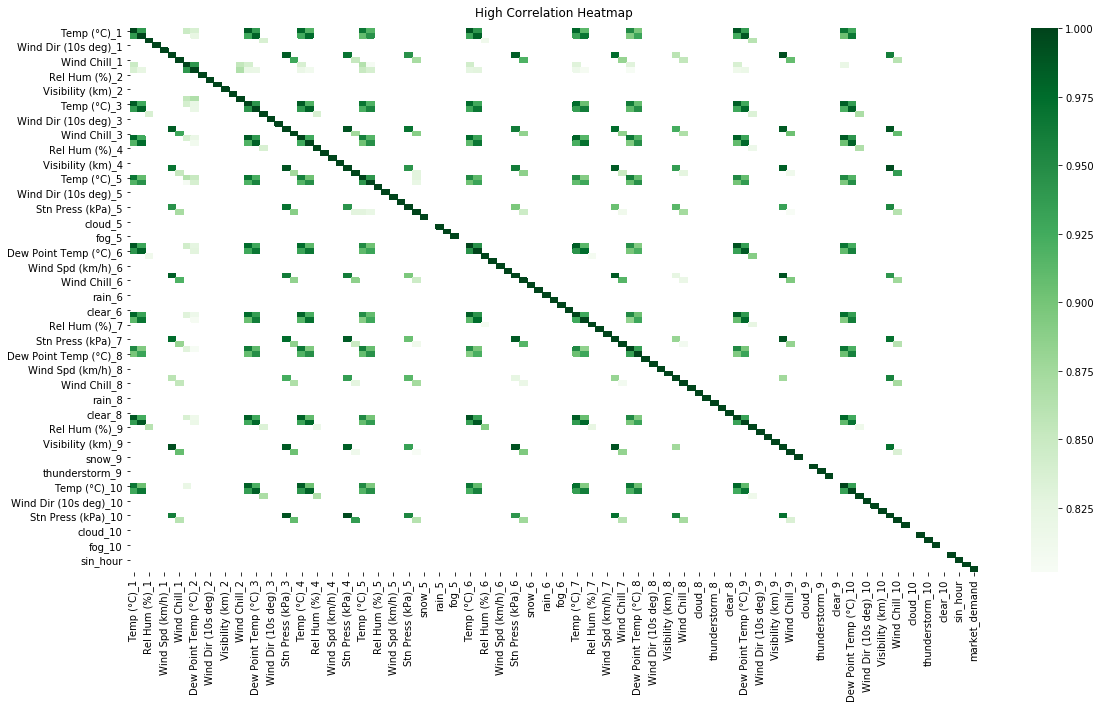

In [20]:
corr = weather_ieso_data.corr()

kot = corr[corr>=.8]
plt.figure(figsize=(19,10))
heatmap_ = sns.heatmap(kot, cmap="Greens")
heatmap_.set_title('High Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.show()

In [9]:
def drop_correlated_features(data, corr_threshold):
    col_corr = set() # Contains feature names 
    corr_matrix = data.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= corr_threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # Retrieve feature name
                col_corr.add(colname)
                if colname in data.columns:
                    del data[colname] # Remove the feature from the dataset

    return data

def redundant_feature_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def top_abs_correlations(df, n=5):
    feat_corr = df.corr().abs().unstack()
    labels_to_drop = redundant_feature_pairs(df)
    feat_corr = feat_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return feat_corr[0:n]

weather_ieso_df = drop_correlated_features(data = weather_ieso_data, corr_threshold = 0.8)

In [22]:
top_abs_correlations(weather_ieso_df, 20)

snow_9             snow_10               0.792035
Wind Chill_1       Wind Chill_2          0.772940
Temp (°C)_1        Wind Chill_1          0.771818
Wind Spd (km/h)_6  Wind Spd (km/h)_9     0.770662
Rel Hum (%)_4      Rel Hum (%)_7         0.769020
Wind Spd (km/h)_1  Wind Spd (km/h)_9     0.756797
Rel Hum (%)_1      Rel Hum (%)_4         0.755818
Wind Spd (km/h)_7  Wind Spd (km/h)_9     0.743504
Wind Spd (km/h)_3  Wind Spd (km/h)_10    0.736142
Wind Spd (km/h)_4  Wind Spd (km/h)_10    0.730090
Rel Hum (%)_1      Rel Hum (%)_7         0.725764
Wind Chill_1       snow_9                0.719064
Wind Spd (km/h)_3  Wind Spd (km/h)_4     0.714962
Wind Chill_1       snow_10               0.709200
Wind Spd (km/h)_1  Wind Spd (km/h)_6     0.708781
Rel Hum (%)_4      Rel Hum (%)_8         0.708605
Rel Hum (%)_5      Rel Hum (%)_8         0.704853
Temp (°C)_1        snow_5                0.703282
                   snow_10               0.691051
                   snow_9                0.689515


In [23]:
print(weather_ieso_df.shape)
weather_ieso_df.head(3)

(35064, 72)


,Temp (°C)_1,Rel Hum (%)_1,Wind Dir (10s deg)_1,Wind Spd (km/h)_1,Stn Press (kPa)_1,Wind Chill_1,Rel Hum (%)_2,Wind Dir (10s deg)_2,Wind Spd (km/h)_2,Visibility (km)_2,Stn Press (kPa)_2,Wind Chill_2,Wind Dir (10s deg)_3,Wind Spd (km/h)_3,Rel Hum (%)_4,Wind Dir (10s deg)_4,Wind Spd (km/h)_4,Visibility (km)_4,Rel Hum (%)_5,Wind Dir (10s deg)_5,Wind Spd (km/h)_5,Visibility (km)_5,snow_5,cloud_5,rain_5,thunderstorm_5,fog_5,clear_5,Wind Dir (10s deg)_6,Wind Spd (km/h)_6,Visibility (km)_6,snow_6,cloud_6,rain_6,thunderstorm_6,fog_6,clear_6,Rel Hum (%)_7,Wind Dir (10s deg)_7,Wind Spd (km/h)_7,Rel Hum (%)_8,Wind Dir (10s deg)_8,Wind Spd (km/h)_8,Visibility (km)_8,snow_8,cloud_8,rain_8,thunderstorm_8,fog_8,clear_8,Wind Dir (10s deg)_9,Wind Spd (km/h)_9,Visibility (km)_9,snow_9,cloud_9,rain_9,thunderstorm_9,fog_9,clear_9,Wind Dir (10s deg)_10,Wind Spd (km/h)_10,Visibility (km)_10,snow_10,cloud_10,rain_10,thunderstorm_10,fog_10,clear_10,weekday,sin_hour,cos_hour,market_demand
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 05:00:00+00:00,-2.8,93.0,25.0,15.0,96.67,-8.0,82.0,28.0,11.0,16.1,98.92,-14.0,23.0,12.0,93.0,24.0,8.0,2.8,97.0,17.0,8.0,4.0,1,0,0,0,0,0,26.0,23.0,24.1,1,0,0,0,0,0,68.0,27.0,20.0,91.0,24.0,10.0,24.1,0,0,0,0,0,1,23.0,21.0,16.1,0,0,1,0,0,0,25.0,15.0,8.1,1,0,0,0,0,0,1,0.000000,1.000000,16767
2016-01-01 06:00:00+00:00,-2.8,91.0,25.0,16.0,96.61,-8.0,81.0,27.0,13.0,16.1,98.88,-14.0,23.0,13.0,91.0,24.0,11.0,2.4,97.0,20.0,5.0,2.4,1,0,0,0,0,0,26.0,25.0,24.1,0,1,0,0,0,0,67.0,27.0,19.0,90.0,29.0,10.0,6.4,1,0,0,0,0,0,25.0,30.0,14.5,0,0,1,0,0,0,23.0,11.0,6.4,1,0,0,0,0,0,1,0.258819,0.965926,16751
2016-01-01 07:00:00+00:00,-3.0,93.0,25.0,20.0,96.56,-9.0,81.0,27.0,15.0,16.1,98.85,-14.0,24.0,14.0,74.0,24.0,18.0,16.1,97.0,24.0,9.0,1.6,1,0,0,0,0,0,25.0,32.0,24.1,1,0,0,0,0,0,70.0,27.0,19.0,92.0,30.0,6.0,4.8,1,0,0,0,0,0,25.0,32.0,16.1,0,0,1,0,0,0,23.0,9.0,4.8,1,0,0,0,0,0,1,0.500000,0.866025,16319


## Lag Feature Selection and Engineering

In [10]:
lag_df = pd.DataFrame(weather_ieso_df['market_demand'])
for i in range(1, 169):
    lag_df["T-{}".format(i)] = lag_df["market_demand"].shift(i)

lag_df = lag_df.dropna()
names = lag_df.columns.values[1:]

In [25]:
lag_df.shape

(34896, 169)

In [11]:
%%time
random.seed(1)
X = lag_df.drop('market_demand', axis = 1)
y = lag_df['market_demand']

# automatically choose the number of features
rfe_cv = RFECV(estimator=LinearRegression(), step = 2, cv = 5, min_features_to_select = 50)
rfe_cv.fit(X, y);
print("Number of selected features:", rfe_cv.n_features_)

Number of selected features: 74
CPU times: user 1min 55s, sys: 10.6 s, total: 2min 6s
Wall time: 55.7 s


In [12]:
rfe_ranking_df = pd.DataFrame(rfe_cv.ranking_, names).reset_index()
rfe_ranking_df.columns = ('feature', 'ranking')
rfe_ranking_df.head(15)

,feature,ranking
0,T-1,1
1,T-2,1
2,T-3,1
3,T-4,1
4,T-5,1
5,T-6,1
6,T-7,1
7,T-8,3
8,T-9,2
9,T-10,1


In [13]:
# Selected lag features
selected_features = []
not_selected_features = []
for i in range(len(rfe_cv.support_)):
    if rfe_cv.support_[i]:
        selected_features.append(names[i])
    else:
        not_selected_features.append(names[i])
print("Selected Features:", selected_features)       
print("")
print("Removed Lag Features:", not_selected_features)

Selected Features: ['T-1', 'T-2', 'T-3', 'T-4', 'T-5', 'T-6', 'T-7', 'T-10', 'T-14', 'T-15', 'T-16', 'T-17', 'T-18', 'T-20', 'T-23', 'T-24', 'T-25', 'T-26', 'T-27', 'T-29', 'T-30', 'T-33', 'T-34', 'T-35', 'T-36', 'T-38', 'T-39', 'T-46', 'T-48', 'T-49', 'T-51', 'T-52', 'T-53', 'T-55', 'T-56', 'T-59', 'T-62', 'T-72', 'T-73', 'T-76', 'T-77', 'T-78', 'T-79', 'T-81', 'T-82', 'T-90', 'T-91', 'T-94', 'T-96', 'T-97', 'T-98', 'T-106', 'T-107', 'T-119', 'T-120', 'T-121', 'T-123', 'T-143', 'T-144', 'T-145', 'T-146', 'T-147', 'T-149', 'T-150', 'T-152', 'T-154', 'T-155', 'T-159', 'T-160', 'T-163', 'T-164', 'T-165', 'T-167', 'T-168']

Removed Lag Features: ['T-8', 'T-9', 'T-11', 'T-12', 'T-13', 'T-19', 'T-21', 'T-22', 'T-28', 'T-31', 'T-32', 'T-37', 'T-40', 'T-41', 'T-42', 'T-43', 'T-44', 'T-45', 'T-47', 'T-50', 'T-54', 'T-57', 'T-58', 'T-60', 'T-61', 'T-63', 'T-64', 'T-65', 'T-66', 'T-67', 'T-68', 'T-69', 'T-70', 'T-71', 'T-74', 'T-75', 'T-80', 'T-83', 'T-84', 'T-85', 'T-86', 'T-87', 'T-88', 'T-89'

## Assigning Lag Variables to the original data

In [14]:
for i in range(1, 169):
    if "T-{}".format(i) in selected_features:
        weather_ieso_df["T-{}".format(i)] = weather_ieso_df["market_demand"].shift(i)
        weather_ieso_df = weather_ieso_df.dropna()

## Monthly and Weekly Averages

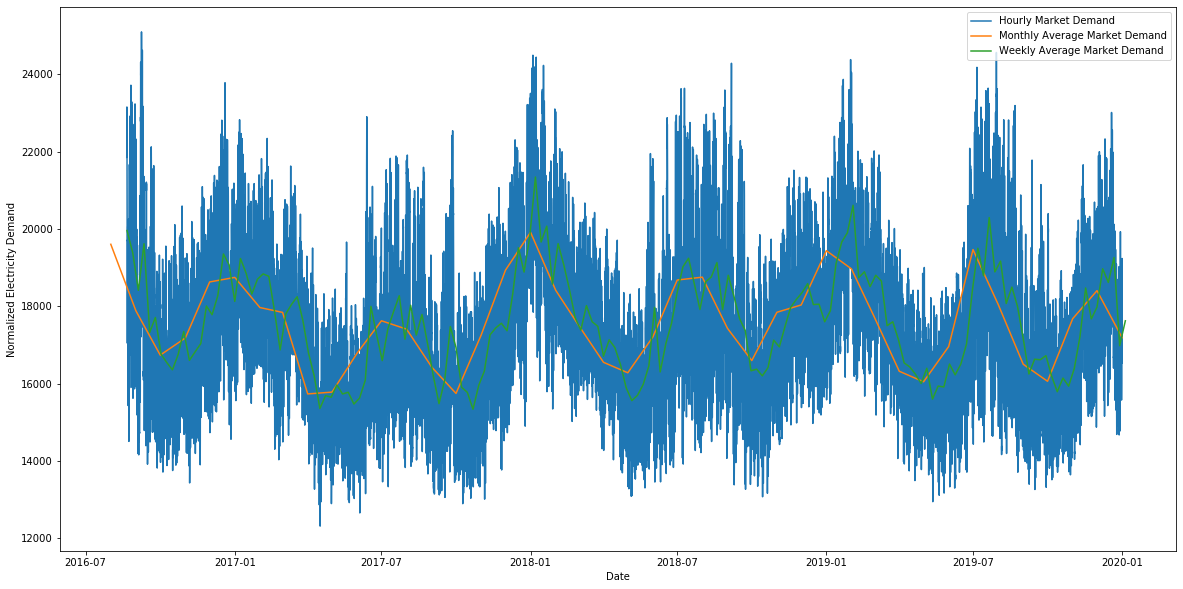

In [30]:
monthly_data = weather_ieso_df['market_demand'].resample('MS').mean()
weekly_data = weather_ieso_df['market_demand'].resample('W').mean()
plt.figure(figsize=(20,10))
plt.plot(weather_ieso_df['market_demand'], label='Hourly Market Demand')
plt.plot(monthly_data, label='Monthly Average Market Demand')
plt.plot(weekly_data, label='Weekly Average Market Demand')
plt.ylabel('Normalized Electricity Demand')
plt.xlabel('Date')
plt.legend(loc='upper right');

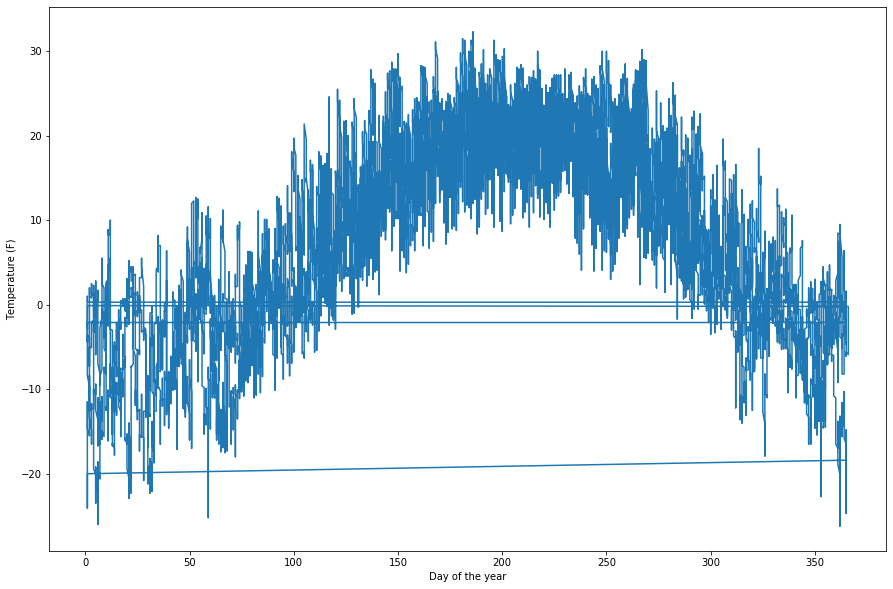

In [31]:
plt.figure(figsize=(15, 10))
plt.plot(weather_ieso_df.index.dayofyear, weather_ieso_df['Temp (°C)_1'])
plt.xlabel('Day of the year')
plt.ylabel('Temperature (F)')
plt.show();

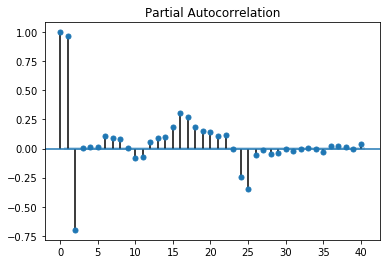

In [32]:
fig = tsaplots.plot_pacf(weather_ieso_df.market_demand, lags=40) 
plt.show()

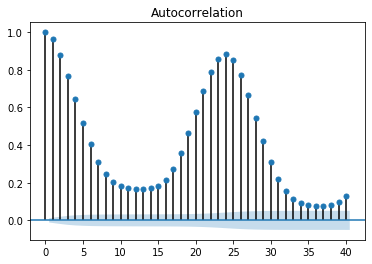

In [33]:
fig = tsaplots.plot_acf(weather_ieso_df.market_demand, lags=40) 
plt.show()

In [34]:
# #Using hourly residuals by subtracting MA from each demand
# weather_ieso_df['market_demand'] = weather_ieso_df['market_demand'].groupby(pd.Grouper(freq='M')).transform(lambda x: x - x.mean())
# plt.figure(figsize=(20,10))
# plt.plot(weather_ieso_df['market_demand'], label='Hourly Demand Residuals')
# plt.ylabel('Normalized Electricity Demand')
# plt.legend();

## Feature Selection for entire dataset

In [15]:
%%time
X = weather_ieso_df.drop(['market_demand'], axis = 1)
y = weather_ieso_df['market_demand']


rfe = RFECV(estimator=LinearRegression(), step = 2, cv = 5, min_features_to_select = 50)
rfe.fit(X, y);
print("Number of selected features:", rfe.n_features_)

rfe_df = pd.DataFrame(rfe.ranking_, X.columns).reset_index()
rfe_df.columns = ('feature', 'ranking')

Number of selected features: 139
CPU times: user 1min 8s, sys: 6.14 s, total: 1min 14s
Wall time: 26.4 s


In [36]:
rfe_df.head(30)

,feature,ranking
0,Temp (°C)_1,1
1,Rel Hum (%)_1,1
2,Wind Dir (10s deg)_1,1
3,Wind Spd (km/h)_1,1
4,Stn Press (kPa)_1,1
5,Wind Chill_1,1
6,Rel Hum (%)_2,1
7,Wind Dir (10s deg)_2,1
8,Wind Spd (km/h)_2,1
9,Visibility (km)_2,1


In [37]:
rfe.n_features_

139

In [16]:
# Selected lag features
final_selected_features = []
final_not_selected_features = []
for i in range(len(rfe.support_)):
    if rfe.support_[i]:
        final_selected_features.append(X.columns[i])
    else:
        final_not_selected_features.append(X.columns[i])
print("Selected Features:", final_selected_features)       
print("")
print("Removed Features:", final_not_selected_features)

Selected Features: ['Temp (°C)_1', 'Rel Hum (%)_1', 'Wind Dir (10s deg)_1', 'Wind Spd (km/h)_1', 'Stn Press (kPa)_1', 'Wind Chill_1', 'Rel Hum (%)_2', 'Wind Dir (10s deg)_2', 'Wind Spd (km/h)_2', 'Visibility (km)_2', 'Stn Press (kPa)_2', 'Wind Chill_2', 'Wind Dir (10s deg)_3', 'Wind Spd (km/h)_3', 'Rel Hum (%)_4', 'Wind Dir (10s deg)_4', 'Wind Spd (km/h)_4', 'Visibility (km)_4', 'Rel Hum (%)_5', 'Wind Dir (10s deg)_5', 'Wind Spd (km/h)_5', 'Visibility (km)_5', 'snow_5', 'rain_5', 'thunderstorm_5', 'fog_5', 'Wind Dir (10s deg)_6', 'Wind Spd (km/h)_6', 'Visibility (km)_6', 'snow_6', 'cloud_6', 'rain_6', 'thunderstorm_6', 'fog_6', 'clear_6', 'Rel Hum (%)_7', 'Wind Dir (10s deg)_7', 'Wind Spd (km/h)_7', 'Rel Hum (%)_8', 'Wind Dir (10s deg)_8', 'Wind Spd (km/h)_8', 'Visibility (km)_8', 'snow_8', 'cloud_8', 'rain_8', 'thunderstorm_8', 'fog_8', 'clear_8', 'Wind Dir (10s deg)_9', 'Wind Spd (km/h)_9', 'Visibility (km)_9', 'snow_9', 'rain_9', 'thunderstorm_9', 'fog_9', 'Wind Dir (10s deg)_10', '

In [39]:
set(weather_ieso_df.columns) - set(final_selected_features)

{'clear_10',
 'clear_5',
 'clear_9',
 'cloud_10',
 'cloud_5',
 'cloud_9',
 'market_demand'}

## Assigning Final Features

In [17]:
weather_ieso_df = weather_ieso_df[final_selected_features]
weather_ieso_df['market_demand'] = y

In [41]:
weather_ieso_df.shape

(29485, 140)

## One hot encoding months of the year

In [18]:
# Capturing and encoding all months
def Jan(x):
    if x.month == 1:
        return 1
    return 0

def Feb(x):
    if x.month == 2:
        return 1
    return 0


def Mar(x):
    if x.month == 3:
        return 1
    return 0

def Apr(x):
    if x.month == 4:
        return 1
    return 0

def May(x):
    if x.month == 5:
        return 1
    return 0

    
def Jun(x):
    if x.month == 6:
        return 1
    return 0

def Jul(x):
    if x.month == 7:
        return 1
    return 0

def Aug(x):
    if x.month == 8:
        return 1
    return 0


def Sep(x):
    if x.month == 9:
        return 1
    return 0

def Oct(x):
    if x.month == 10:
        return 1
    return 0

    
def Nov(x):
    if x.month == 11:
        return 1
    return 0

def Dec(x):
    if x.month == 12:
        return 1
    return 0

weather_ieso_df['January'] = weather_ieso_df.index.to_series().apply(Jan)
weather_ieso_df['February'] = weather_ieso_df.index.to_series().apply(Feb)
weather_ieso_df['March'] = weather_ieso_df.index.to_series().apply(Mar)
weather_ieso_df['April'] = weather_ieso_df.index.to_series().apply(Apr)
weather_ieso_df['May'] = weather_ieso_df.index.to_series().apply(May)
weather_ieso_df['June'] = weather_ieso_df.index.to_series().apply(Jun)
weather_ieso_df['July'] = weather_ieso_df.index.to_series().apply(Jul)
weather_ieso_df['August'] = weather_ieso_df.index.to_series().apply(Aug)
weather_ieso_df['September'] = weather_ieso_df.index.to_series().apply(Sep)
weather_ieso_df['October'] = weather_ieso_df.index.to_series().apply(Oct)
weather_ieso_df['November'] = weather_ieso_df.index.to_series().apply(Nov)
weather_ieso_df['December'] = weather_ieso_df.index.to_series().apply(Dec)

In [24]:
weather_ieso_df.to_csv("data/cleaned/final_weather_ieso_df_ready.csv")

In [43]:
weather_ieso_df

,Temp (°C)_1,Rel Hum (%)_1,Wind Dir (10s deg)_1,Wind Spd (km/h)_1,Stn Press (kPa)_1,Wind Chill_1,Rel Hum (%)_2,Wind Dir (10s deg)_2,Wind Spd (km/h)_2,Visibility (km)_2,Stn Press (kPa)_2,Wind Chill_2,Wind Dir (10s deg)_3,Wind Spd (km/h)_3,Rel Hum (%)_4,Wind Dir (10s deg)_4,Wind Spd (km/h)_4,Visibility (km)_4,Rel Hum (%)_5,Wind Dir (10s deg)_5,Wind Spd (km/h)_5,Visibility (km)_5,snow_5,rain_5,thunderstorm_5,fog_5,Wind Dir (10s deg)_6,Wind Spd (km/h)_6,Visibility (km)_6,snow_6,cloud_6,rain_6,thunderstorm_6,fog_6,clear_6,Rel Hum (%)_7,Wind Dir (10s deg)_7,Wind Spd (km/h)_7,Rel Hum (%)_8,Wind Dir (10s deg)_8,Wind Spd (km/h)_8,Visibility (km)_8,snow_8,cloud_8,rain_8,thunderstorm_8,fog_8,clear_8,Wind Dir (10s deg)_9,Wind Spd (km/h)_9,Visibility (km)_9,snow_9,rain_9,thunderstorm_9,fog_9,Wind Dir (10s deg)_10,Wind Spd (km/h)_10,Visibility (km)_10,snow_10,rain_10,thunderstorm_10,fog_10,weekday,sin_hour,cos_hour,T-1,T-2,T-3,T-4,T-5,T-6,T-7,T-10,T-14,T-15,T-16,T-17,T-18,T-20,T-23,T-24,T-25,T-26,T-27,T-29,T-30,T-33,T-34,T-35,T-36,T-38,T-39,T-46,T-48,T-49,T-51,T-52,T-53,T-55,T-56,T-59,T-62,T-72,T-73,T-76,T-77,T-78,T-79,T-81,T-82,T-90,T-91,T-94,T-96,T-97,T-98,T-106,T-107,T-119,T-120,T-121,T-123,T-143,T-144,T-145,T-146,T-147,T-149,T-150,T-152,T-154,T-155,T-159,T-160,T-163,T-164,T-165,T-167,T-168,market_demand,January,February,March,April,May,June,July,August,September,October,November,December
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-08-20 16:00:00+00:00,25.9,67.0,22.0,15.0,96.11,-2.0,80.0,25.0,4.0,16.1,98.20,-2.0,25.0,7.0,74.0,16.0,13.0,16.1,76.0,24.0,17.0,16.1,0,1,0,0,17.0,21.0,24.1,0,1,0,0,0,0,62.0,20.0,14.0,56.0,18.0,17.0,24.1,0,1,0,0,0,0,20.0,17.0,16.1,0,0,0,1,20.0,11.0,16.1,0,0,0,1,0,2.588190e-01,-0.965926,21550.0,20737.0,19760.0,18837.0,17781.0,16953.0,16933.0,17386.0,21499.0,22545.0,22771.0,22817.0,23666.0,24022.0,22785.0,22293.0,21963.0,21163.0,20993.0,18730.0,17744.0,16721.0,16964.0,17375.0,18221.0,21033.0,22785.0,22796.0,21999.0,21664.0,20621.0,19908.0,18902.0,16611.0,16282.0,16714.0,21074.0,20561.0,20140.0,19347.0,18470.0,17421.0,16158.0,15556.0,15849.0,22255.0,22624.0,21924.0,21652.0,21673.0,21452.0,17050.0,17608.0,21841.0,21511.0,21429.0,19862.0,20643.0,20588.0,20085.0,19365.0,18311.0,15661.0,15733.0,16040.0,16536.0,16902.0,20786.0,21426.0,22309.0,21909.0,21770.0,22407.0,22327.0,21851,0,0,0,0,0,0,0,1,0,0,0,0
2016-08-20 17:00:00+00:00,26.8,60.0,19.0,12.0,96.04,-2.0,77.0,25.0,4.0,16.1,98.14,-2.0,18.0,13.0,70.0,19.0,13.0,16.1,69.0,23.0,18.0,16.1,0,1,0,0,17.0,23.0,24.1,0,1,0,0,0,0,52.0,20.0,14.0,54.0,16.0,24.0,24.1,0,1,0,0,0,0,20.0,13.0,16.1,0,0,0,1,18.0,17.0,16.1,0,0,0,1,0,1.224647e-16,-1.000000,21851.0,21550.0,20737.0,19760.0,18837.0,17781.0,16953.0,17169.0,19934.0,21499.0,22545.0,22771.0,22817.0,24001.0,23226.0,22785.0,22293.0,21963.0,21163.0,20096.0,18730.0,16547.0,16721.0,16964.0,17375.0,19456.0,21033.0,23081.0,22371.0,21999.0,21008.0,20621.0,19908.0,17806.0,16611.0,16361.0,19520.0,20916.0,20561.0,19594.0,19347.0,18470.0,17421.0,15676.0,15556.0,21801.0,22255.0,21938.0,22276.0,21652.0,21673.0,16856.0,17050.0,22083.0,21841.0,21511.0,20924.0,20967.0,20643.0,20588.0,20085.0,19365.0,16865.0,15661.0,15705.0,16165.0,16536.0,19837.0,20786.0,21715.0,22309.0,21909.0,21842.0,22407.0,22340,0,0,0,0,0,0,0,1,0,0,0,0
2016-08-20 18:00:00+00:00,27.0,61.0,18.0,15.0,95.98,-2.0,73.0,25.0,9.0,16.1,98.11,-2.0,18.0,10.0,61.0,19.0,15.0,16.1,63.0,24.0,15.0,16.1,0,1,0,0,17.0,29.0,24.1,0,1,0,0,0,0,54.0,19.0,15.0,53.0,18.0,26.0,24.1,0,1,0,0,0,0,19.0,15.0,16.1,0,0,0,1,17.0,18.0,16.1,0,0,0,1,0,-2.588190e-01,-0.965926,22340.0,21851.0,21550.0,20737.0,19760.0,18837.0,17781.0,16821.0,18653.0,19934.0,21499.0,22545.0,22771.0,23666.0,23830.0,23226.0,22785.0,22293.0,21963.0,20993.0,20096.0,16925.0,16547.0,16721.0,16964.0,18221.0,19456.0,23575.0,22796.0,22371.0,21664.0,21008.0,20621.0,18902.0,17806.0,16233.0,17972.0,21407.0,20916.0,19963.0,195

In [5]:
# weather_ieso_df = pd.read_csv("data/cleaned/final_weather_ieso_df_ready.csv")
# weather_ieso_df = weather_ieso_df.set_index('date_time', drop = True)

## To-do: Handle Leap Year 2016

## Models

In [6]:
X = weather_ieso_df.drop(['market_demand'], axis = 1)
y = weather_ieso_df['market_demand']


def gridsearchcv(model, param_grid, n_splits = 10, verbose = True):

    """GridSearchCV with TimeSeriesSplit. Input parameters should have 'model__' prefix"""
    scaler = MinMaxScaler()

    pipe = Pipeline([
            ('scale', scaler),
            ('model', model)])

    if verbose:
        grid_search = GridSearchCV(pipe, param_grid = param_grid, scoring='neg_root_mean_squared_error',
                cv=TimeSeriesSplit(n_splits=n_splits).split(X), verbose=10, n_jobs=-1, refit=True)
    else:
        grid_search = GridSearchCV(pipe, param_grid = param_grid, scoring='neg_root_mean_squared_error',
                cv=TimeSeriesSplit(n_splits=n_splits).split(X), verbose=0, n_jobs=-1, refit=True)
    grid_search.fit(X,y);
    
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)
    
    return grid_search

## LinearRegression

In [48]:
model_lr = LinearRegression()
param_grid_lr = {'model__fit_intercept': [True, False]}

lr_grid_search = gridsearchcv(model_lr, param_grid_lr)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    3.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.9s finished


Best Parameters: {'model__fit_intercept': False}
Best Score: -2642.7647264762372


## XGBRegressor

In [7]:
model_xgb = XGBRegressor(objective='reg:squarederror')
param_grid_xgb = {'model__max_depth' : [2, 5, 10], 
                   'model__learning_rate': [.01, 0.1]}

xgb_grid_search = gridsearchcv(model_xgb, param_grid_xgb)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.9min finished


Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 10}
Best Score: -300.1107348993922


## Top 30 important features

In [55]:
xgb_grid_search.best_estimator_['model']

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

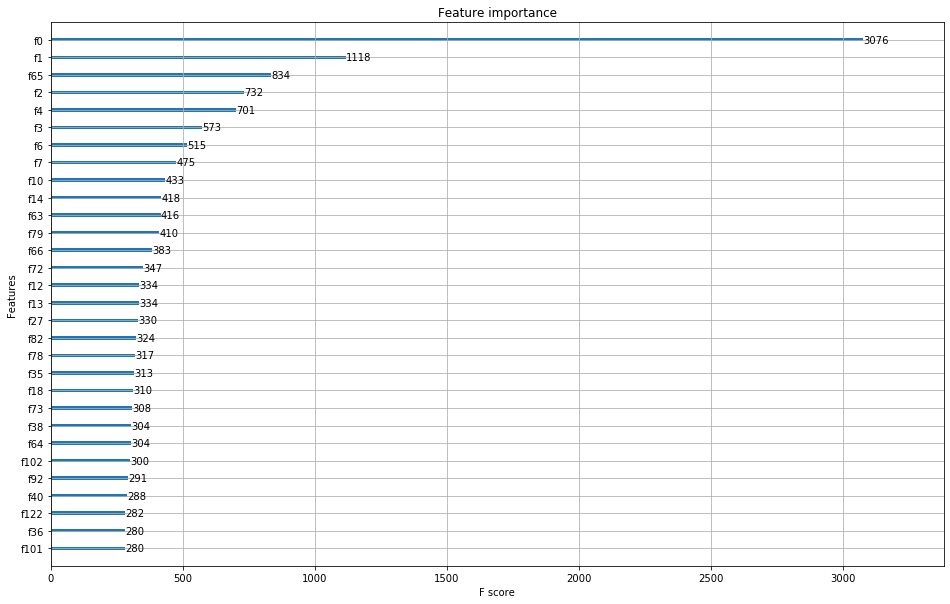

In [8]:
#Top 30 important features
plt.rcParams["figure.figsize"] = (16, 10)
plot_importance(xgb_grid_search.best_estimator_['model'], max_num_features=30)
plt.show()

- To-do: Extract original feature names

## Multi-layer Perceptron regressor - MLPRegressor

In [ ]:
# 'model__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,1)],         

In [ ]:
# model_mlpr = MLPRegressor(max_iter=700000)

# param_grid_mlpr = {
#         'model__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],    
#         'model__activation': ['relu','tanh'],
#         'model__alpha': [0.0001, 0.05],
#         'model__learning_rate': ['constant','adaptive'],
#         'model__solver': ['adam', 'sgd']
# }

# mlpr_grid_search = gridsearchcv(model_mlpr, param_grid_mlpr, n_splits=5, verbose = True)

In [7]:
model_mlpr = MLPRegressor(max_iter=700000, activation='relu', learning_rate = 'adaptive', solver = 'adam')

param_grid_mlpr = { 
        'model__alpha': [0.0001, 0.01]
}

mlpr_grid_search = gridsearchcv(model_mlpr, param_grid_mlpr, n_splits=5, verbose = True)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 23.2min remaining: 23.2min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 41.3min remaining: 17.7min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 72.0min finished


Best Parameters: {'model__alpha': 0.01}
Best Score: -726.2163953374585


## To-do: LSTM

In [ ]:
# def lstm_model(n_lags, n_hours, cells=50, learning_rate=5e-3):
    
#     #define the model
#     model = Sequential()
#     model.add(LSTM(cells, activation='relu', return_sequences=True, input_shape=(n_lags, n_hours)))
#     model.add(LSTM(int(cells/2), activation='relu'))
#     model.add(Dense(n_hours))
    
#     #define the learning rate
#     optimizer = Adam(lr=learning_rate)
    
#     #compile model
#     model.compile(optimizer=optimizer, loss='mae')
    
#     return model

### Improve

In [40]:
def train_test_ts(df, test_size = 0.15, scale = False, cols_to_transform=None):
    """
    
        Splits data into train-test while preserving temporal structure
        
        - df: dataframe with variables X to train on and the dependent output y (market demand)
        - test_size: size of test set, default 0.15
        - scale: if set to True, the columns in the cols_to_transform list will be scaled using StandardScaler
        - cols_to_transform: List of columns to be scaled
        
    """
    data = df.copy()
    # obtain the starting index of test set
    test_index = int(len(data)*(1-test_size))
    
    # StandardScaler fit on the entire dataset
    if scale:
        scaler = StandardScaler()
        data[cols_to_transform] = scaler.fit_transform(data[cols_to_transform])
        
    X_train = data.drop('SDGE', axis = 1).iloc[:test_index]
    y_train = data.SDGE.iloc[:test_index]
    X_test = data.drop('SDGE', axis = 1).iloc[test_index:]
    y_test = data.SDGE.iloc[test_index:]
    
    # StandardScaler fit only on the training set
    if scale and not include_test_scale:
        scaler = StandardScaler()
        X_train[cols_to_transform] = scaler.fit_transform(X_train[cols_to_transform])
        X_test[cols_to_transform] = scaler.transform(X_test[cols_to_transform])
    
    return X_train, X_test, y_train, y_test

In [30]:
X = weather_ieso_df.drop(['market_demand'], axis = 1)
y = weather_ieso_df['market_demand']

In [25]:

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, train_size = 0.8, random_state=1)

In [35]:
# %%time
# # train MLP model, and get validation set performance
# def get_mlp_mae(hl, a, lr, mi):
#     mod = MLPRegressor(hidden_layer_sizes=hl, alpha=a, learning_rate_init=lr, max_iter=mi)
#     mod.fit(X_train, y_train)
#     pred_val = mod.predict(X_test)
#     return mean_absolute_error(y_test, pred_val)

# # define potential sets of hyperparameters
# hidden_layer_sizes = [(100,),(500,),(100,10,),(100,100,)]
# alpha = [0.0001, 0.001]
# learning_rate = [0.0001, 0.001, 0.01]
# max_iter = [200, 1000, 10000]
# grid_search = pd.DataFrame(columns=['hl','a','lr','mi','mae'])

# # perform grid search
# for hl in hidden_layer_sizes:    
#     for a in alpha:        
#         for lr in learning_rate:
#             for mi in max_iter:
#                 mae = get_mlp_mae(hl, a, lr, mi)
#                 params = {'hl':hl, 'a':a, 'lr':lr, 'mi':mi, 'mae':mae} 
#                 grid_search = grid_search.append(params, ignore_index=True)


In [37]:
def weekly_forecast(model=0, exog, y_init):
    """given a trained model exogenous features, and initial AR term, makes a series of 1-week-out forecasts"""
    yhat = []
    for i, yi in enumerate(y_init):
        exog_i = exog[168*i:168*(i+1),:]
#         if exog_i.shape[0] < 1:
#             break
#         yhat.append(forecast(model, exog_i, yi))
    return exog_i#np.hstack(yhat)

In [ ]:
np.hstack([y_train[-1], validate.iloc[167::168,0].values])

In [39]:
X_test.iloc[167::168]

,Temp (°C)_1,Rel Hum (%)_1,Wind Dir (10s deg)_1,Wind Spd (km/h)_1,Stn Press (kPa)_1,Wind Chill_1,Rel Hum (%)_2,Wind Dir (10s deg)_2,Wind Spd (km/h)_2,Visibility (km)_2,Stn Press (kPa)_2,Wind Chill_2,Wind Dir (10s deg)_3,Wind Spd (km/h)_3,Rel Hum (%)_4,Wind Dir (10s deg)_4,Wind Spd (km/h)_4,Visibility (km)_4,Rel Hum (%)_5,Wind Dir (10s deg)_5,Wind Spd (km/h)_5,Visibility (km)_5,snow_5,rain_5,thunderstorm_5,fog_5,Wind Dir (10s deg)_6,Wind Spd (km/h)_6,Visibility (km)_6,snow_6,cloud_6,rain_6,thunderstorm_6,fog_6,clear_6,Rel Hum (%)_7,Wind Dir (10s deg)_7,Wind Spd (km/h)_7,Rel Hum (%)_8,Wind Dir (10s deg)_8,Wind Spd (km/h)_8,Visibility (km)_8,snow_8,cloud_8,rain_8,thunderstorm_8,fog_8,clear_8,Wind Dir (10s deg)_9,Wind Spd (km/h)_9,Visibility (km)_9,snow_9,rain_9,thunderstorm_9,fog_9,Wind Dir (10s deg)_10,Wind Spd (km/h)_10,Visibility (km)_10,snow_10,rain_10,thunderstorm_10,fog_10,weekday,sin_hour,cos_hour,T-1,T-2,T-3,T-4,T-5,T-6,T-7,T-10,T-14,T-15,T-16,T-17,T-18,T-20,T-23,T-24,T-25,T-26,T-27,T-29,T-30,T-33,T-34,T-35,T-36,T-38,T-39,T-46,T-48,T-49,T-51,T-52,T-53,T-55,T-56,T-59,T-62,T-72,T-73,T-76,T-77,T-78,T-79,T-81,T-82,T-90,T-91,T-94,T-96,T-97,T-98,T-106,T-107,T-119,T-120,T-121,T-123,T-143,T-144,T-145,T-146,T-147,T-149,T-150,T-152,T-154,T-155,T-159,T-160,T-163,T-164,T-165,T-167,T-168,January,February,March,April,May,June,July,August,September,October,November,December
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-05-07 11:00:00+00:00,3.8,82.0,32.0,6.0,97.21,-4.0,97.0,27.0,8.0,16.1,100.32,-8.0,31.0,17.0,88.0,32.0,8.0,16.1,100.0,34.0,17.0,16.1,0,0,0,1,35.0,8.0,19.3,0,0,1,0,0,0,91.0,36.0,11.0,80.0,30.0,14.0,24.1,0,1,0,0,0,0,32.0,9.0,16.1,0,1,0,0,31.0,11.0,16.1,0,1,0,0,1,1.0,6.123234e-17,15382.0,14172.0,13765.0,13641.0,13666.0,13816.0,14303.0,16644.0,16959.0,16626.0,16583.0,16844.0,16621.0,16019.0,16295.0,16590.0,15909.0,15259.0,14262.0,14123.0,14078.0,16298.0,17124.0,16948.0,16684.0,16329.0,15786.0,15376.0,15062.0,15042.0,14751.0,14570.0,14672.0,15473.0,15632.0,16111.0,16318.0,15765.0,15405.0,15120.0,15144.0,15071.0,15179.0,16231.0,17114.0,16848.0,17011.0,17222.0,16808.0,16051.0,15098.0,17247.0,17611.0,17570.0,17267.0,15942.0,14305.0,18012.0,17304.0,16524.0,15779.0,15755.0,15404.0,15202.0,15693.0,17897.0,18019.0,16505.0,15948.0,16727.0,16240.0,16250.0,17305.0,17659.0,0,0,0,0,1,0,0,0,0,0,0,0
2019-05-14 11:00:00+00:00,4.6,95.0,33.0,9.0,96.36,-1.0,96.0,29.0,0.0,16.1,98.76,-2.0,3.0,11.0,92.0,1.0,15.0,16.1,75.0,31.0,17.0,16.1,0,1,0,0,33.0,16.0,24.1,0,0,1,0,0,0,94.0,35.0,9.0,95.0,6.0,14.0,16.1,0,0,1,0,0,0,33.0,18.0,16.1,0,1,0,0,36.0,11.0,16.1,0,1,0,0,1,1.0,6.123234e-17,15948.0,15175.0,14847.0,14472.0,14470.0,14729.0,14878.0,17266.0,17978.0,18010.0,17752.0,17369.0,17221.0,17355.0,16797.0,16577.0,15610.0,14346.0,14536.0,14314.0,14217.0,15525.0,16188.0,16432.0,16102.0,16486.0,16543.0,15668.0,14433.0,13724.0,13070.0,13173.0,13572.0,14295.0,14711.0,15669.0,15420.0,14232.0,13677.0,13815.0,13772.0,13892.0,14566.0,15764.0,16389.0,16971.0,16913.0,17001.0,16131.0,15427.0,14614.0,16569.0,16742.0,17262.0,16421.0,15644.0,13983.0,16018.0,16040.0,14956.0,14546.0,13760.0,13806.0,14014.0,14966.0,16642.0,16963.0,16077.0,16072.0,15694.0,15496.0,15835.0,16680.0,16654.0,0,0,0,0,1,0,0,0,0,0,0,0
2019-05-21 11:00:00+00:00,2.5,96.0,29.0,4.0,97.02,-1.0,96.0,26.0,8.0,16.1,99.89,-3.0,31.0,15.0,72.0,30.0,21.0,16.1,93.0,31.0,34.0,16.1,0,1,0,1,28.0,8.0,24.1,0,0,0,0,0,1,84.0,29.0,11.0,74.0,30.0,28.0,24.1,0,1,0,0,0,0,31.0,13.0,16.1,0,1,0,0,32.0,21.0,16.1,0,1,0,0,1,1.0,6.123234e-17,15373.0,14605.0,14076.0,14035.0,14098.0,14642.0,15030.0,16418.0,16261.0,15757.0,15455.0,15493.0,15143.0,15209.0,14469.0,13818.0,13442.0,13345.0,13113.0,13252.0,13623.0,16051.0,16982.0,17360.0,17002.0,16768.0,16291.0,14907.0,14313.0,14150.0,13450.0,13740.0,13928.0,14460.0,15022.0,16979.0,16369.0,14819.0,14501.0,14369.0,14387.0,14534.0,14868.0,16164.0,16921.0,16471.0,16469.0,1646